<div class='bar_title'></div>

*Introduction to Data Science*

# Spatial Data Analytics

Gunther Gust<br>
Chair for Enterprise AI

Winter Semester 24/25

<img src="images/d3.png" style="width:20%; float:left;" />

<img src="images/CAIDASlogo.png" style="width:20%; float:left;" />

# Content

* Conventional (non-spatial) Regression
* Regression Models for Spatial Heterogeneity 
* Regression Models for Spatial Dependence



*Credits: Most of the material is taken from [Rey et al (2023): Geographic Data Science with Python](https://geographicdata.science/book/intro.html)*

# Why Spatial Regression Models?

Explain or predict phenomena for which __geography matters__

**A) The process that generates the data is spatial**

Examples:
* __House prices__ are higher closer to the city center
* __Covid 19 infections__ spread accross space


**B) There are spatial associations in the data (even though we might not know why)**

Examples:
* __Spatial structure in our errors:__ geography should be an attribute somehow, but we are not sure how to include it in our model
    * Some other __ommitted feature__ causes spatial patterns in the error
    * __Interactions and interdependencies__ between included features cause spatial patterns in the error

Overall, regardless of whether or not the true process is explicitly geographic, additional information about the __spatial relationships__ between our observations or more information about nearby sites can make our __predictions better.__

## *What* is spatial regression and *why* should I care?


1. Space can have an impact on our data. The __process__ *generating* the data might itself be explicitly __spatial:__ prices for single family homes (paying a premium on the house price in order to live in a better school district for the same quality house); homes closer to noise or chemical polluters like waste water treatment plants, recycling facilities, or wide highways, may actually be cheaper than we would otherwise anticipate

$\Rightarrow$ *geography is a feature*: it directly helps us make __better predictions__ about outcomes *because those outcomes are obtained from geographical processes*

2. Among other kinds of __error diagnostics,__ geography provides us with an exceptionally useful embedding to assess structure in our errors.
Mapping classification/prediction error can help show whether or not there are __*clusters of error*__ in our data.
If we *know* that errors tend to be larger in some areas than in other areas (or if error is "contagious" between observations), then we might be able to exploit this structure to make better predictions.

* Spatial structure in errors may arise when geography should be an attribute but isn't included in the model or due to other missing features.
* Many predictors in models of social processes inherently contain embodied spatial information, reflecting intrinsic patterns.
* Using spatially patterned predictors, intentionally or not, can create spatially patterned errors, and combining multiple such predictors can amplify this effect.
* Even if the true process isn’t explicitly geographic, adding information about spatial relationships or nearby sites can improve predictions.

This chapter integrates space into the traditional regression framework. We start with a standard linear regression model without geographical references.

Space and spatial relationships are formalized in three main ways:

1. __Exogenous variables:__ Encoding spatial information directly into predictors.
2. __Spatial heterogeneity:__ Systematic variation of outcomes across space.
3. __Spatial dependence:__ Effects tied to the characteristics of spatial neighbors.

The focus is on conceptual differences rather than technical details.

## Task: Predict San Diego Airbnb Prices



We'll examine information about Airbnb properties in San Diego, CA. 
This dataset contains house intrinsic characteristics, both continuous (number of beds as in `beds`) and categorical (type of renting or, in Airbnb jargon, property group as in the series of `pg_X` binary variables), but also variables that explicitly refer to the location and spatial configuration of the dataset (e.g., distance to Balboa Park, `d2balboa` or neighborhood id, `neighborhood_cleansed`).

In [1]:
from pysal.lib import weights
from pysal.explore import esda
import numpy
import pandas
import geopandas
import matplotlib.pyplot as plt
import seaborn
import contextily

import warnings
warnings.filterwarnings("ignore")

C:\Users\ggust\anaconda3\envs\sc_gsda_l9\lib\site-packages\spaghetti\network.py:40: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)
C:\Users\ggust\anaconda3\envs\sc_gsda_l9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
db =  geopandas.read_file("https://raw.githubusercontent.com/GuntherGust/sc_gdsa_data/main/regression_db.geojson")

These are the explanatory variables we will use throughout the chapter.

In [3]:
variable_names = [
    "accommodates",  # Number of people it accommodates
    "bathrooms",  # Number of bathrooms
    "bedrooms",  # Number of bedrooms
    "beds",  # Number of beds
    # Below are binary variables, 1 True, 0 False
    "rt_Private_room",  # Room type: private room
    "rt_Shared_room",  # Room type: shared room
    "pg_Condominium",  # Property group: condo
    "pg_House",  # Property group: house
    "pg_Other",  # Property group: other
    "pg_Townhouse",  # Property group: townhouse
]

In [4]:
db.head()

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,id,pg_Apartment,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,6,0,0,1,0,0,1,0,0,POINT (-117.12971 32.75399)
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,5570,0,1,0,0,0,1,0,0,POINT (-117.25253 32.78421)
2,2,1.0,1.0,1.0,North Hills,0,2.493893,0,99.0,4.595120,9553,1,0,0,0,0,0,1,0,POINT (-117.14121 32.75327)
3,2,1.0,1.0,1.0,Mira Mesa,0,22.293757,0,72.0,4.276666,14668,0,0,1,0,0,0,1,0,POINT (-117.15269 32.93110)
4,2,1.0,1.0,1.0,Roseville,0,6.829451,0,55.0,4.007333,38245,0,0,1,0,0,0,1,0,POINT (-117.21870 32.74202)


We can plot geospatial data using the `contextily` package that adds tile maps to matplotlib figures to give us an understanding of the geographical dimension of our data.

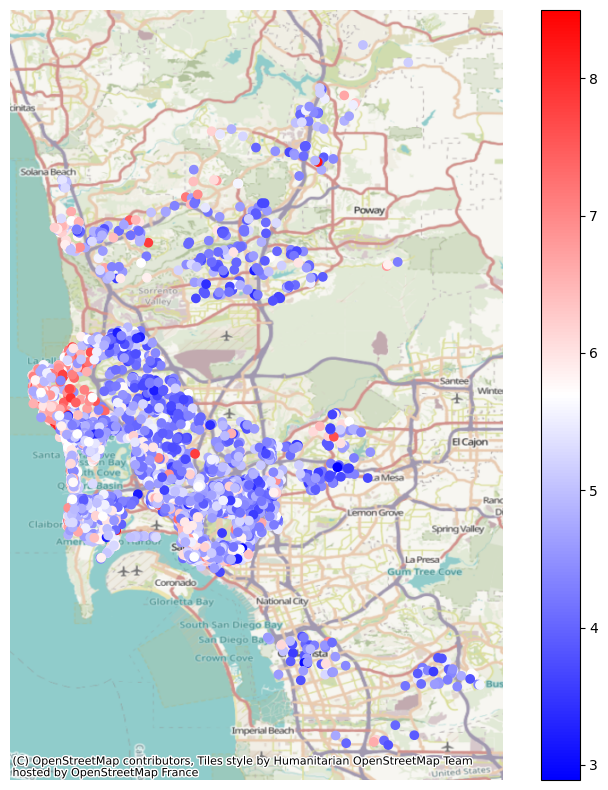

In [5]:
ax = db.plot(column = "log_price", figsize = (10,10), cmap = "bwr", legend = True)
# Add basemap
contextily.add_basemap(ax=ax,crs=db.crs)
# Remove axes
ax.set_axis_off();

## Non-spatial regression, a (very) quick refresh

$$
P_i = \alpha + \sum_k \mathbf{X}_{ik}\beta_k  + \epsilon_i
$$

* $P_i$ is the Airbnb price of house $i$

* $X_{ik}$ is a set of covariates $k \in K$ to explain such price (e.g., no. of bedrooms, bathrooms,...)

*  $\beta_k$ desribes how covariate $k$ is related to the price 

* the intercept $\alpha$ is the average house price when all the other variables are zero

* $\epsilon_i$ is the "error" term and captures elements that influence the price of a house but are not included in $X$

For a quick recap of the intuition of regression modeling, see e.g. [this video](https://www.youtube.com/watch?v=PaFPbb66DxQ). For a more formal and thorough coverage, I recommend _Wooldridge (2019), Introductory Econometrics: A Modern Approach (Part 1)._

Before we discuss how to explicitly include space into the linear regression framework, let us show how basic regression can be carried out in Python, and how one can begin to interpret the results.

The core idea of linear regression is to explain the variation in a given (*dependent*) variable as a linear function of a collection of other (*explanatory*) variables.
In our case: express the price of a house as a function of the number of bedrooms and whether it is a condominium or not. At the individual level, we can express this as:

$$
P_i = \alpha + \sum_k \mathbf{X}_{ik}\beta_k  + \epsilon_i
$$

where

* $P_i$ is the Airbnb price of house $i$
* $X$ is a set of covariates or features that we use to explain such price (e.g., No. of bedrooms and condominium binary variable)
* $\beta$ is a vector of parameters that give us information about in which way and to what extent each variable is related to the price
* $\alpha$, the constant term, is the average house price when all the other variables are zero
* $\epsilon_i$ is usually referred to as "error" and captures elements that influence the price of a house but are not included in $X$

We can also express this relation in matrix form, excluding sub-indices for $i$, which yields:

$$
P = \alpha + \mathbf{X}\beta + \epsilon
$$

## Non-spatial regression in Python

Practically speaking, linear regressions in Python are rather streamlined and easy to work with. There are also several packages which will run them (e.g., `statsmodels`, `scikit-learn`, `pysal`). 



In the context of this chapter, it makes sense to start with `spreg`, as that is the only library that will allow us to move into explicitly spatial econometric models.

In [6]:
from pysal.model import spreg

In [7]:
# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    y= db[["log_price"]].values,
    # Independent variables
    x = db[variable_names].values,
    # Dependent variable name
    name_y="log_price",
    # Independent variable name
    name_x=variable_names,
)

* We use the command `OLS`, part of the `spreg` sub-package, and specify the dependent variable (the __log of the price__, so we can interpret results in terms of percentage change in the dependent variable for a one-unit change in the independent variable) and the explanatory ones. 

* Note that both objects need to be arrays, so we extract them from the `pandas.DataFrame` object using `.values`.



In order to inspect the results of the model, we can print the `summary` attribute:

In [8]:
print(m1.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          11
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6099
R-squared           :      0.6683
Adjusted R-squared  :      0.6678
Sum squared residual:     1320.15                F-statistic           :   1229.0564
Sigma-square        :       0.216                Prob(F-statistic)     :           0
S.E. of regression  :       0.465                Log likelihood        :   -3988.895
Sigma-square ML     :       0.216                Akaike info criterion :    7999.790
S.E of regression ML:      0.4648                Schwarz criterion     :    8073.685

------------------------------------------------------------

# Exercise 1:

Please interpret the previous output of the regression analysis: Which independent variables are most relevant? How would you judge the overall fit of the model?

_Answer here_


### Hidden structures

In general, our model performs well ($R^2=0.67$)
But, our model might display some __clustering in the errors__, which may be a problem as that violates the i.i.d. assumption linear models usually come built-in with. 




#### Options to analyze spatial structures in the error term
* Split our data up __by regions__ and see if we've got some __spatial structure in our residuals.__ 

 
    * Differing errors by proximity to the beach
    * Differing errors by neighborhood
    * ...

* Look at the __correlation between the error__ in predicting an Airbnb and the __error in predicting its nearest neighbor.__  


### 1. Spatial proximity to the beach

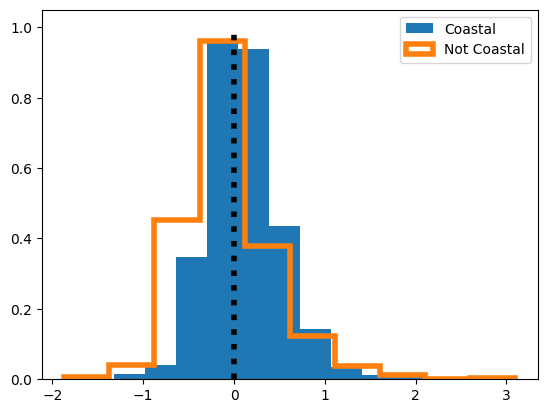

In [9]:
# Create a Boolean (True/False) with whether a
# property is coastal or not
is_coastal = db.coastal.astype(bool)
# Split residuals (m1.u) between coastal and not
coastal = m1.u[is_coastal] #coastal 
not_coastal = m1.u[~is_coastal] #non-coastal ("~" inverts the variable)
# Create histogram of the distribution of coastal residuals
plt.hist(coastal, density=True, label="Coastal")
# Create histogram of the distribution of non-coastal residuals
plt.hist(
    not_coastal,
    histtype="step",
    density=True,
    linewidth=4,
    label="Not Coastal",
)
# Add Line on 0
plt.vlines(0, 0, 1, linestyle=":", color="k", linewidth=4)
# Add legend
plt.legend()
# Display
plt.show()

While it appears that the neighborhoods on the coast have only slightly higher average errors (and have lower variance in their prediction errors), the two distributions are significantly distinct from one another when compared using a classic __$t$-test__:

In [10]:
from scipy.stats import ttest_ind # independent two-sample t-test 

ttest_ind(coastal, not_coastal) # t-test to compare means of 'coastal' and 'not_coastal' groups

TtestResult(statistic=array([13.98193858]), pvalue=array([9.442438e-44]), df=array([6108.]))

### 2. Errors by neighborhood

Some neighborhoods may be more desirable than others due to unmodeled latent preferences or factors like marketing.
For example, despite proximity to the sea, living near Camp Pendleton (a Marine base) may reduce desirability due to noise and pollution.

Domain knowledge and data analysis can help identify such patterns.
To investigate, we can examine the full distribution of model residuals within each neighborhood: We'll sort the data by the median residual in each neighborhood and create a boxplot to visualize residual distributions.

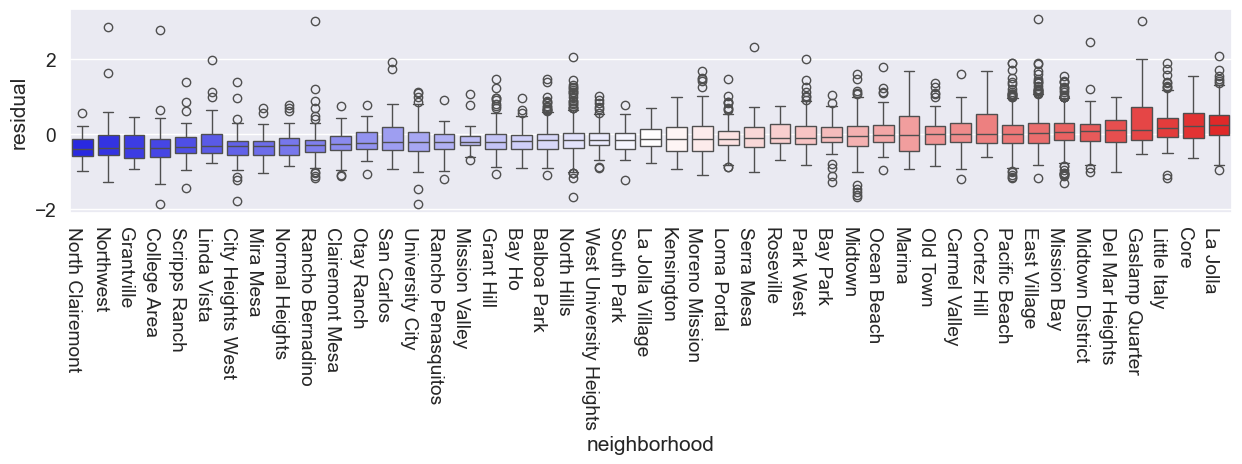

In [11]:
# Create column with residual values from m1
db["residual"] = m1.u
# Obtain the median value of residuals in each neighborhood
medians = (
    db.groupby("neighborhood")
    .residual.median()
    .to_frame("hood_residual")
)

db2 = db.merge(medians, how="left", left_on="neighborhood", right_index=True)

# Increase fontsize
seaborn.set(font_scale=1.25)
# Set up figure
f = plt.figure(figsize=(15, 3))
# Grab figure's axis
ax = plt.gca()
# Generate bloxplot of values by neighborhood
# Note the data includes the median values merged on-the-fly
seaborn.boxplot(
    x="neighborhood",
    y="residual",
    ax=ax,
    data=db2.sort_values("hood_residual"),
    hue="neighborhood",
    palette = "bwr"
)
# Rotate the X labels for legibility
f.autofmt_xdate(rotation=-90)
# Display
plt.show()

# Exercise
What does this plot tell you?

_Answer here_

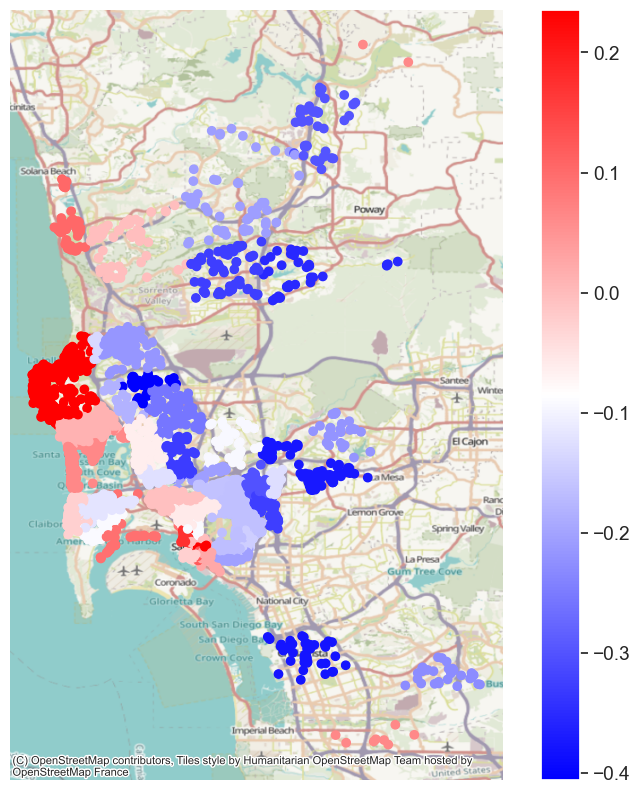

In [12]:
ax = db2.plot("hood_residual", cmap = "bwr", legend = True, figsize=(10,10))
contextily.add_basemap(ax=ax,crs=db2.crs)
ax.set_axis_off()

* Neighborhoods are interconnected, but some, like the Gaslamp Quarter, Little Italy, or The Core, stand out as higher in desirability.
* This suggests a potential effect of intangible neighborhood fashionableness in the model.
* Many of the most over- and under-predicted neighborhoods are geographically close, hinting at possible contagion or spatial spillovers in nightly rent prices.
* This pattern often arises as individuals price their Airbnb listings competitively with nearby listings.

Since the model doesn’t account for this behavior, errors may cluster spatially.

### 3. Residual vs. Lagged Residual 

One exceptionally simple way we can look into this structure is by examining the relationship between an observation's residuals and its surrounding residuals. 



* Spatial weights represent geographic relationships between observations in a spatially referenced dataset.
* They are widely used to compute relationships between all pairs of observations, enabling statistical analysis of spatial data.
* By building a topology—a mathematical structure expressing connectivity—we can examine data holistically rather than focusing on individual nearby features.
* Spatial weights matrices embed all observations in space, allowing comprehensive analysis beyond localized questions like “What neighborhoods are nearby?” or “How many gas stations are within 5 miles?”

There are different ways of capturing spatial relationships, including:
- **contiguity weights**: A contiguous pair of spatial objects are those that share a common border.
- **spatial weights from surfaces**: weights derived from continuous spatial surfaces, such as elevation, temperature, population density, or other raster-based geographic data
- **block weights**: connect every observation in a dataset that belongs to the same category in a provided list
- **distance-based weights**: Usually, this means that a matrix expressing the distances between all pairs of observations are required. These are then provided to a kernel function which uses the proximity information to model proximity as a smooth function of distance.

Here we illustrate a selection beginning with the notion of nearest neighbor weights.


__K-Nearest Neighbors (KNN) weights__ are a type of spatial weight structure where each spatial unit is connected to its __k-nearest neighbors__ based on geographic distance or another proximity measure. This approach ensures that each unit has exactly k neighbors, regardless of the spatial distribution of the data, making it particularly useful for datasets with uneven spatial density.

We will use a $KNN$ matrix where $k=1$, i.e meaning we're focusing only on the linkages of each Airbnb to their closest other listing.

In [13]:
knn = weights.KNN.from_dataframe(db, k=1)

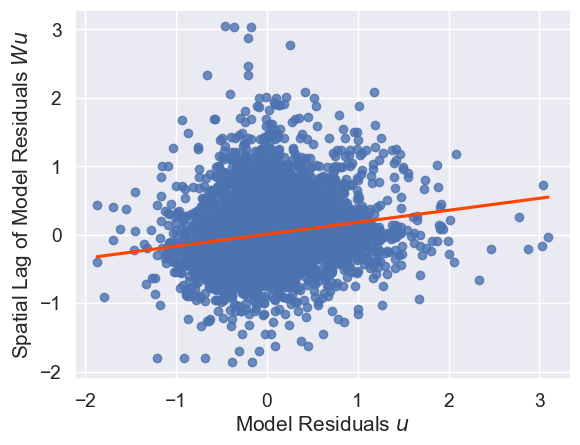

In [14]:
# compute the spatial lag of the vector of residuals
lag_residual = weights.spatial_lag.lag_spatial(w = knn, y = m1.u)
ax = seaborn.regplot(
    x=m1.u.flatten(),
    y=lag_residual.flatten(),
    line_kws=dict(color="orangered"),
    ci=None,
)
ax.set_xlabel("Model Residuals $u$")
ax.set_ylabel("Spatial Lag of Model Residuals $W u$");

Above, we show the relationship between our prediction error at each site and the prediction error at the site nearest to it. 
Here, we're using this nearest site to stand in for the *surroundings* of that Airbnb. 
This means that, when the model tends __to over-predict a given Airbnb's nightly log price__, sites around that Airbnb are more likely to __*also be over-predicted*.__ An interesting property of this relationship is that it tends to stabilize as the number of nearest neighbors used to construct each Airbnb's surroundings increases.


### 4. Identify local Hot and Coldspots


- The relationship between the stable surrounding average and a focal Airbnb can reveal clusters in model errors using the __local Moran__ statistic.
- Local Moran is a measure of local __spatial autocorrelation,__ evaluating whether a data point and its spatial neighbors have similar or dissimilar values.
- As a localized version of Global Moran's I, it offers a more granular analysis of geographic hotspots and coldspots compared to the global measure.

The value of the local Moran $I_i$ helps identify clusters or outliers in the data:

- Positive $I_i$: The value at location i is similar to its neighbors (e.g., high values surrounded by high values or low values surrounded by low values). This indicates a cluster.
- Negative $I_i$: The value at location i is dissimilar to its neighbors (e.g., a high value surrounded by low values or vice versa). This indicates a spatial outlier.

We will now identify certain areas where our predictions of the nightly (log) Airbnb price tend to be significantly off:

In [15]:
# Re-weight W to 20 nearest neighbors
knn.reweight(k=20, inplace=True)
# Row standardize weights
knn.transform = "R"
# Run LISA on residuals
outliers = esda.moran.Moran_Local(m1.u, knn, permutations=9999)

In [16]:
# selects the observations that are in odd quadrants (1 and 3), 
# which typically represent clusters of similar values (e.g., high-high and low-low clusters). 
hot_and_cold = outliers.q % 2 == 1

#filter out insignificant observations
significant = outliers.p_sim <= 0.001  
hot_and_cold  = hot_and_cold  & significant  

#add the info to the dataframe
db3 = db.assign(
        error_clusters=hot_and_cold ,
        local_I=outliers.Is)

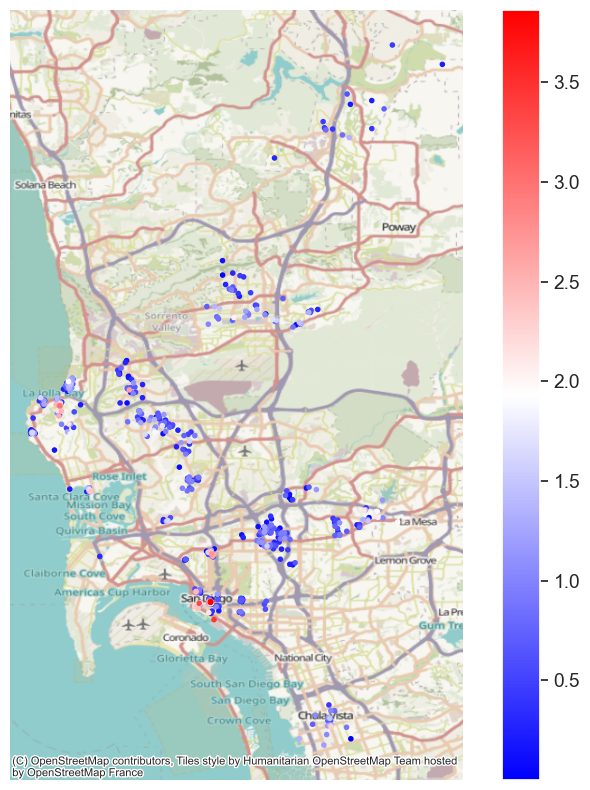

In [17]:
# Add `error_clusters` and `local_I` columns
ax = db3.query("error_clusters").sort_values(
    "local_I"  # Sort by I value to largest plot on top
    ).plot("local_I", cmap="bwr", marker=".", figsize=(10,10), legend = True)   # Plot I values

# Add basemap
contextily.add_basemap(ax, crs=db.crs)
# Remove axes
ax.set_axis_off();

__Significant under- and over-predictions do appear to cluster__ in a highly structured way. 

We might be able to use a __better model to fix the geography of our model errors!__ If they have a consistent geography that we can model — then we might make our predictions even better, or at least not systematically mis-predict prices in some areas while correctly predicting prices in other areas. 

## Bringing space into the regression framework

__Spatial regression__ = introducing __space__ into the __regression model.__



__Two motivations:__

a)  We think space plays an __important role in the process__ 

Example: We can imagine that houses at the seafront are probably more expensive than those in the second row, given their better views


b)  Space can act as a reasonable __proxy__ for other factors that we cannot but should include in our model
    
Example: The character of a neighborhood is important in determining the price of a house:
        - However, it is very hard to identify and quantify "character" per se 
        - It might be easier to get its spatial variation, hence a case of space as a proxy.
    

We will study __three approaches__:

1. Spatial feature engineering & conventional (non-spatial) regression
2. Spatial regression to model spatial heterogeneity
3. Spatial regression to model spatial dependence

- Spatial regression methods are designed to address spatial structures by explicitly incorporating geographic context into regression models.
- Space should be included in a model when it is expected to play a significant role in the process being studied (e.g., seafront houses likely being more expensive due to better views).
- Spatial regression is a growing field in econometrics and statistics, addressing two key processes:
    - Spatial heterogeneity: Systematic variation across space.
    - Spatial dependence: Influence of nearby observations on each other.

- An alternative approach is to create spatially explicit independent variables without altering the regression model itself.

For more detailed treatments, refer to:

    Luc Anselin (2003): Spatial externalities, spatial multipliers, and spatial econometrics.
    Luc Anselin & Sergio J. Rey (2014): Modern Spatial Econometrics in Practice.
    Andrew Gelman & Jennifer Hill (2006): Data Analysis Using Regression and Multilevel Hierarchical Models.

### 1) Spatial feature engineering: proximity variables

In this section, we will briefly present how to __insert spatial features__ (= variables that are constructed from geographical relationships), in a __standard linear model.__


__Example__: 
    __Proximity to Balboa Park,__ a common tourist destination, could be an important __*spatially patterned omitted covariate*__: geographic information our model needs to make good predictions which we have left out of our model.

To address this, we will build a new model incorporating the distance to Balboa Park, starting by visualizing the structure of this distance covariate.

Luckily the __distance to Balboa Park__ (`d2balboa`, in km) has already been precomputed for us (see [here](https://geographicdata.science/book/data/airbnb/regression_cleaning.html) for how this was done):

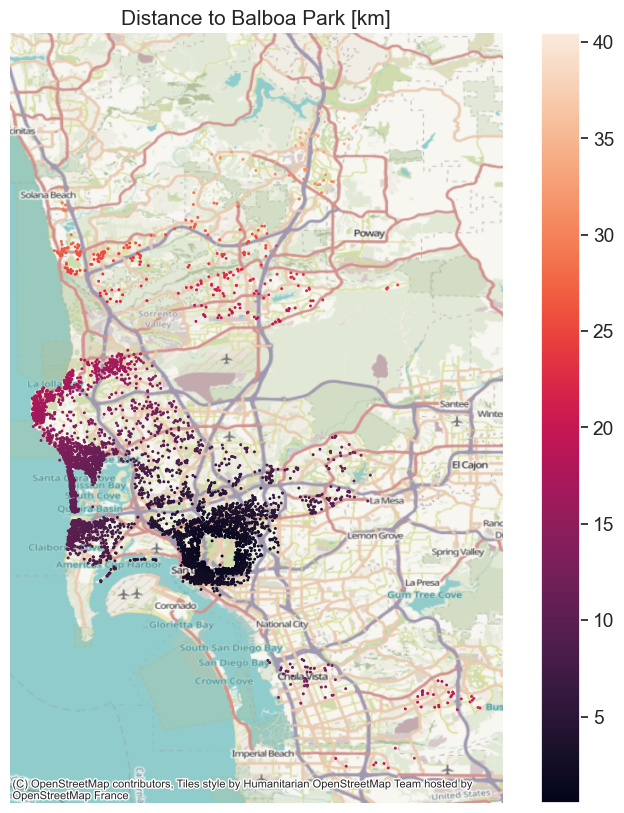

In [18]:
ax = db.plot(column="d2balboa", marker=".", s=5, legend = True, figsize=(10,10))
contextily.add_basemap(ax, crs=db.crs)
ax.set_title("Distance to Balboa Park [km]")
ax.set_axis_off();

To run a linear model that includes the additional variable of distance to the park, we add the name to the list of variables we included originally:

In [19]:
balboa_names = variable_names + ["d2balboa"]

And then fit the model using the OLS class in Pysal's `spreg`:

In [20]:
m2 = spreg.OLS(
    db[["log_price"]].values,
    db[balboa_names].values,
    name_y="log_price",
    name_x=balboa_names,
)

When you inspect the regression diagnostics and output, you see that this covariate is not quite as helpful as we might anticipate:

In [21]:
pandas.DataFrame(
    [[m1.r2, m1.ar2], [m2.r2, m2.ar2]],
    index=["M1", "M2"],
    columns=["R2", "Adj. R2"],
)

,R2,Adj. R2
M1,0.668345,0.667801
M2,0.668502,0.667904


The model fit does not substantially change. `D2Balboa` is not statistically significant at conventional significance levels:

In [22]:
# Set up table of regression coefficients
pandas.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m2.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m2.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m2.t_stat],
    },
    index=m2.name_x,
)

,Coeff.,Std. Error,P-Value
CONSTANT,4.379624,0.016915,0.000000e+00
accommodates,0.083644,0.005079,1.156896e-59
bathrooms,0.190791,0.011005,9.120139e-66
bedrooms,0.150746,0.011179,7.418035e-41
beds,-0.041476,0.006939,2.394322e-09
rt_Private_room,-0.552996,0.015960,2.680270e-240
rt_Shared_room,-1.235521,0.038462,2.586867e-209
pg_Condominium,0.140459,0.022225,2.803765e-10
pg_House,-0.013302,0.014623,3.630396e-01
pg_Other,0.141176,0.022798,6.309880e-10


The distance to Balboa Park variable does not fit our theory about how distance to amenity should affect the price of an Airbnb; the __coefficient estimate__ is __positive__, meaning that people are paying a premium to be further from Balboa Park. 



And, there still appears to be spatial structure in our model's errors, as we can see in the figure below:

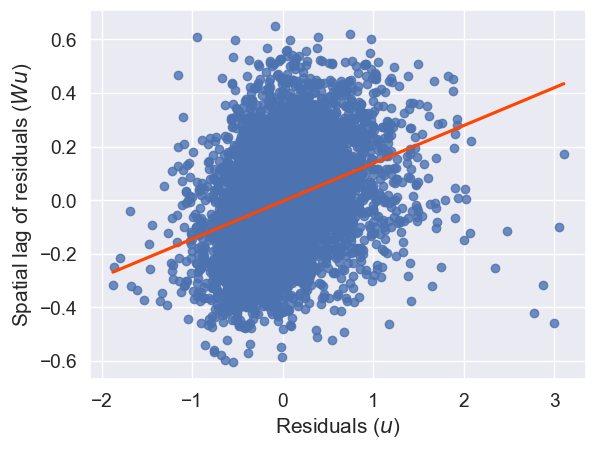

In [23]:
lag_residual = weights.spatial_lag.lag_spatial(knn, m2.u)
ax = seaborn.regplot(
    x=m2.u.flatten(),
    y=lag_residual.flatten(),
    line_kws=dict(color="orangered"),
    ci=None,
)
ax.set_xlabel("Residuals ($u$)")
ax.set_ylabel("Spatial lag of residuals ($Wu$)");

Finally, the distance to Balboa Park variable does not fit our theory about how distance to amenity should affect the price of an Airbnb; the coefficient estimate is *positive*, meaning that people are paying a premium to be *further* from Balboa Park.

### 2. Spatial regression to model spatial heterogeneity



So far we have assumed that our proximity variable might stand in for a difficult-to-measure premium individuals pay when they're close to a recreational zone (a park in this case). Our approach in that case was to incorporate space through a very specific channel, that is the distance to an amenity we thought might be influencing the final price. However, not all neighborhoods have the same house prices; some neighborhoods may be systematically more expensive than others, regardless of their proximity to Balboa Park. If this is our case, we need some way to account for the fact that each neighborhood may experience these kinds of *gestalt*, unique effects. One way to do this is by capturing *spatial heterogeneity* (SH).

__Spatial heterogeneity__ means that parts of the model may __vary systematically with geography.__ 


For example, 

* Changes to the __intercept 𝛼__ may reflect the fact that different areas have different baseline exposures to a given process. 
    * E.g. different AirBnB prices per neighborhood

* Changes to the __slope terms  𝛽__ may indicate some kind of __geographical mediating factor__ that makes the relationship between the independent and dependent variables vary across space
    * E.g. prices for additional beds increase more strongly in the city center

* Finally, changes to the __variance of the residuals__, commonly denoted __𝜎2__ can introduce __spatial heteroskedasticity.__
    * E.g. higher price levels and thus larger price variations in the city center


We deal with the first two in this lecture.


### Spatial fixed effects

The literature commonly refers to geographic variations of $\alpha$ as "spatial fixed effects (FE)".

To illustrate them, let us consider the house price example from the previous section. Sometimes, spatial fixed effects are said to capture __"space as a proxy",__ in that we know the outcome varies over space, we (hope to) know the pattern it follows (in our case, by neighborhood) and we can thus incorporate that knowledge into the model by __letting $\alpha$ vary accordingly.__ 

The rationale goes as follows. Given we are only including a few explanatory variables in the model, it is likely we are __missing some important factors__ that play a role at determining the price at which a house is sold. Some of them, however, are likely to __vary systematically over space (e.g., by neighborhood characteristics).__  


We can __control for those unobserved factors__ by using traditional binary variables but basing their creation on a spatial rule. 

For example, let us include a binary variable for every neighborhood, indicating whether a given house is located within such area (`1`) or not (`0`). This is basically what we already know as One-Hot encoding. Mathematically, we are now fitting the following equation:

$$
\log{P_i} = \alpha_r + \sum_k \mathbf{X}_{ik}\beta_k  + \epsilon_i
$$

where the main difference is that we are now __allowing the constant term, $\alpha$, to vary by neighborhood $r$, $\alpha_r$.__

Programmatically, we will show two different ways we can estimate this: one,
using `statsmodels`; and two, with `spreg`. First, we will use `statsmodels`, the econometrician's toolbox in Python. 

#### Excursus (study on your own): Spatial fixed effects using `statsmodels`

In [24]:
import statsmodels.formula.api as sm

This package provides a __formula-like API__, which allows us to express the *equation* we wish to estimate directly:

In [25]:
# Start building a formula string for a statistical model
f = (
    "log_price ~ "  # Set 'log_price' as the dependent variable
    + " + ".join(variable_names)  # Add independent variables from 'variable_names' list
    + " + neighborhood - 1"  # Include 'neighborhood' as an independent variable, exclude intercept
)
print(f)

log_price ~ accommodates + bathrooms + bedrooms + beds + rt_Private_room + rt_Shared_room + pg_Condominium + pg_House + pg_Other + pg_Townhouse + neighborhood - 1


The *tilde* operator in this statement is usually read as "log price is a function of ...", to account for the fact that many different model specifications can be fit according to that functional relationship between `log_price` and our covariate list. Critically, note that the trailing `-1` term means that we are fitting this model __without an intercept term.__ This is necessary, since including an intercept term alongside unique means for every neighborhood would make the underlying system of equations underspecified.

Using this expression, we can estimate the unique effects of each neighborhood, fitting the model in `statsmodels` (note how the specification of the model, formula and data is separated from the fitting step): 

In [26]:
m3 = sm.ols(f, data=db).fit()

We will illustrate how you can extract the spatial fixed effects into a table for display.

In [27]:
# Store variable names for all the spatial fixed effects
sfe_names = [i for i in m3.params.index if "neighborhood[" in i]
# Create table
pandas.DataFrame(
    {
        "Coef.": m3.params[sfe_names],
        "Std. Error": m3.bse[sfe_names],
        "P-Value": m3.pvalues[sfe_names],
    }
)

,Coef.,Std. Error,P-Value
neighborhood[Balboa Park],4.280766,0.033292,0.0
neighborhood[Bay Ho],4.198251,0.076878,0.0
neighborhood[Bay Park],4.329223,0.050987,0.0
neighborhood[Carmel Valley],4.389261,0.056553,0.0
neighborhood[City Heights West],4.053518,0.058378,0.0
neighborhood[Clairemont Mesa],4.095259,0.047699,0.0
neighborhood[College Area],4.033697,0.058258,0.0
neighborhood[Core],4.726186,0.052643,0.0
neighborhood[Cortez Hill],4.608090,0.051526,0.0
neighborhood[Del Mar Heights],4.496910,0.054337,0.0


The approach above shows how spatial FE are a particular case of a linear regression with a categorical  variable. Neighborhood membership is modeled using binary dummy variables. Thanks to the formula grammar used in `statsmodels`, we can express the model abstractly, and Python parses it, appropriately creating binary variables as required.


### The same model using the Spatial Regression Models (`spreg`) package

The second approach leverages `spreg` Regimes functionality. We will see regimes below but, for now, think of them as a generalization of spatial fixed effects where not only $\alpha$ can vary. This framework allows the user to specify which variables are to be estimated separately for each group. In this case, instead of describing the model in a formula, we need to pass each element of the model as separate arguments.

The `spreg` framework allows the user to specify which variables are to be estimated separately for each group, so-called __regime:__
* intercept __𝛼__
* slope terms  __𝛽__
* variance of the residuals __𝜎2__

We start by allowing only the intercept __𝛼__ to vary:

In [28]:
# spreg spatial fixed effect implementation
m4 = spreg.OLS_Regimes(
    # Dependent variable
    y = db[["log_price"]].values,
    # Independent variables
    x = db[variable_names].values,
    # Variable specifying regime membership
    regimes = db["neighborhood"].tolist(),
    # Allow the constant term to vary by group/regime
    constant_regi="many",
    # Variables to be allowed to vary (True) or kept
    # constant (False). Here we set all to False
    cols2regi=[False] * len(variable_names),
    # Allow separate sigma coefficients to be estimated
    # by regime (False so a single sigma)
    regime_err_sep=False,
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=variable_names,
)

For simplicity here, we will only confirm that, to the 12th decimal, the parameters estimated are indeed the same as those we get from `statsmodels`:

In [29]:
import numpy

numpy.round(m4.betas.flatten() - m3.params.values, decimals=12)

array([-0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,
        0.,  0.,  0.])

We can see here, that our two models estimate the same parameters since their difference is zero. It is a question of taste which model to prefer in this case.

### Evaluating the neighborhood-fixed effects



To make a map of neighborhood fixed effects, we need to process the results from our model slightly.

First, we extract only the effects pertaining to the neighborhoods:

In [30]:
neighborhood_effects = m3.params.filter(like="neighborhood")
neighborhood_effects.head(10)

neighborhood[Balboa Park]          4.280766
neighborhood[Bay Ho]               4.198251
neighborhood[Bay Park]             4.329223
neighborhood[Carmel Valley]        4.389261
neighborhood[City Heights West]    4.053518
neighborhood[Clairemont Mesa]      4.095259
neighborhood[College Area]         4.033697
neighborhood[Core]                 4.726186
neighborhood[Cortez Hill]          4.608090
neighborhood[Del Mar Heights]      4.496910
dtype: float64

Extract neighborhood names:

In [31]:
# Create a sequence with the variable names without
# `neighborhood[` and `]`
stripped = neighborhood_effects.index.str.strip(
    "neighborhood["
).str.strip("]")
# Reindex the neighborhood_effects Series on clean names
neighborhood_effects.index = stripped
# Convert Series to DataFrame
neighborhood_effects = neighborhood_effects.to_frame("fixed_effect")
# Print top of table
neighborhood_effects.head(10)

,fixed_effect
Balboa Park,4.280766
Bay Ho,4.198251
Bay Park,4.329223
Carmel Valley,4.389261
City Heights West,4.053518
Clairemont Mesa,4.095259
College Area,4.033697
Core,4.726186
Cortez Hill,4.608090
Del Mar Heights,4.496910


Merge the datasets:

In [32]:
db_fe = db.merge(neighborhood_effects, 
                 how = "left", 
                 left_on = "neighborhood" , 
                 right_index=True)

Create the plot:

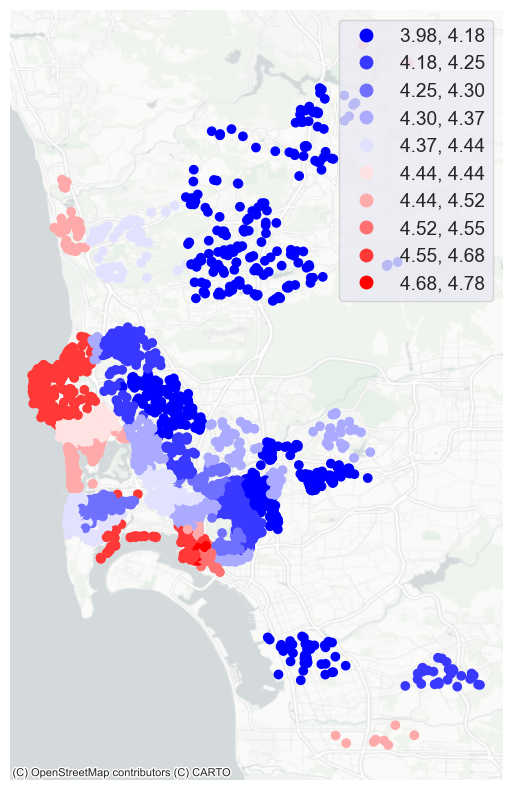

In [33]:
# Plot quantile choropleth
ax = db_fe.plot(
    "fixed_effect",  # Variable to display
    scheme="quantiles",  # Choropleth scheme
    k=10,  # No. of classes in the choropleth
    cmap="bwr",  # Color scheme
    legend = True,
    figsize = (10,10)
)
# Add basemap
contextily.add_basemap(
    ax,
    crs=db.crs,
    source=contextily.providers.CartoDB.PositronNoLabels)
# Remove axis
ax.set_axis_off()
# Display
plt.show()

We can see a clear spatial structure in the SFE estimates. The most expensive neighborhoods tend to be located near the coast and in the city center, while the cheapest ones are more inland.

__Question__ (to explore on your own): How do the remaining error terms differ in comparison to the non-spatial model?

### Spatial Regimes - Next Level of spatial regression: Allow for varying slope terms ($\beta_{k-r}$) 

The idea of spatial regimes (SRs) is to generalize the spatial FE approach to allow __not only the constant__ term to vary __but also any other explanatory variable.__ This implies that the equation we will be estimating is:

$$
\log{P_i} = \alpha_r + \sum_k \mathbf{X}_{ki}\beta_{k-r} + \epsilon_i
$$

where we are not only allowing the constant term to vary by region ($\alpha_r$), but also every other parameter ($\beta_{k-r}$).

### Example: Coastal vs. non-costal neighborhoods

To illustrate this approach, we will use the "spatial differentiator" of whether a house is in a coastal neighborhood or not (`coastal_neig`) to define the regimes. 

The rationale behind this choice is that renting a house close to the ocean might be a strong enough pull that people might be willing to pay at different *rates* for each of the house's characteristics.


To implement this in Python, we use again the `OLS_Regimes` class in `spreg`, which does most of the heavy lifting for us:

In [34]:
# Pysal spatial regimes implementation
m5 = spreg.OLS_Regimes(
    # Dependent variable
    y = db[["log_price"]].values,
    # Independent variables
    x = db[variable_names].values,
    # Variable specifying regime membership
    regimes = db["coastal"].tolist(),
    # Allow the constant term to vary by group/regime
    constant_regi="many",
    # Allow all explanatory variables to vary accross regimes
    cols2regi='all', 
    # Don't allow separate sigma coefficients by regime
    regime_err_sep=False,
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=variable_names,
)

The result can be explored and interpreted similarly to the previous ones. If you inspect the `summary` attribute, you will find the parameters for each variable mostly conform to what you would expect, across both regimes. 


To compare the results, we can plot them side-by-side on a bespoke table :

In [35]:
# Results table
res = pandas.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m5.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m5.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m5.t_stat],
    },
    index=m5.name_x,
)
# Coastal regime
## Extract variables for the coastal regime
coastal = [i for i in res.index if "1_" in i]
## Subset results to coastal and remove the 1_ underscore
coastal = res.loc[coastal, :].rename(lambda i: i.replace("1_", ""))
## Build multi-index column names
coastal.columns = pandas.MultiIndex.from_product(
    [["Coastal"], coastal.columns]
)
# Non-coastal model
## Extract variables for the non-coastal regime
ncoastal = [i for i in res.index if "0_" in i]
## Subset results to non-coastal and remove the 0_ underscore
ncoastal = res.loc[ncoastal, :].rename(lambda i: i.replace("0_", ""))
## Build multi-index column names
ncoastal.columns = pandas.MultiIndex.from_product(
    [["Non-coastal"], ncoastal.columns]
)
# Concat both models
pandas.concat([coastal, ncoastal], axis=1)

Coastal                          Non-coastal             \
                   Coeff. Std. Error       P-Value      Coeff. Std. Error   
CONSTANT         4.479904   0.025094  0.000000e+00    4.407242   0.021516   
accommodates     0.048464   0.007881  8.253761e-10    0.090186   0.006474   
bathrooms        0.247478   0.016566  1.381278e-49    0.143376   0.014268   
bedrooms         0.189740   0.017923  5.783965e-26    0.112963   0.013827   
beds            -0.050608   0.010743  2.522348e-06   -0.026272   0.008838   
rt_Private_room -0.558628   0.028312  4.723759e-84   -0.529334   0.018918   
rt_Shared_room  -1.052854   0.084174  1.836512e-35   -1.224459   0.042597   
pg_Condominium   0.204447   0.033943  1.810152e-09    0.105307   0.028131   
pg_House         0.075353   0.023378  1.274269e-03   -0.045447   0.017957   
pg_Other         0.295485   0.038645  2.394157e-14    0.060753   0.027637   
pg_Townhouse    -0.073508   0.049367  1.365396e-01   -0.010397   0.045673   

                                
                       P-Value  
CONSTANT          0.000000e+00  
accommodates      1.893020e-43  
bathrooms         1.418804e-23  
bedrooms          3.731742e-16  
beds              2.964354e-03  
rt_Private_room  3.546091e-162  
rt_Shared_room   1.657163e-170  
pg_Condominium    1.831822e-04  
pg_House          1.140318e-02  
pg_Other          2.796727e-02  
pg_Townhouse      8.199294e-01

### Key Question:  Statistical significance of regimes? Or: Do the introduced regimes really make a difference?

For this, the model object also calculates for us what is called a __Chow test.__ This is a statistic that tests the __null hypothesis__ that estimates from different regimes are __undistinguishable.__ If we reject the null hypothesis, we have evidence suggesting the regimes actually make a difference.

Results from the Chow test are available on the `summary` attribute, or we can extract them directly from the model object, which we will do here. 

There are two types of Chow test:

1. __Global test__ that jointly tests for differences between the two regimes:

In [36]:
m5.chow.joint

(328.8690214302763, 7.11354876738264e-64)

The first value represents the statistic, while the second one captures the p-value. In this case, the two regimes are __statistically different__ from each other. 

2.  __Test per coefficient:__ Do coefficients __differ across regimes?__ 

In [37]:
pandas.DataFrame(
    # Chow results by variable
    m5.chow.regi,
    # Name of variables
    index=m5.name_x_r,
    # Column names
    columns=["Statistic", "P-value"],
)

,Statistic,P-value
CONSTANT,4.832180,2.793329e-02
accommodates,16.735685,4.296522e-05
bathrooms,22.671471,1.922004e-06
bedrooms,11.503786,6.945459e-04
beds,3.060313,8.022620e-02
rt_Private_room,0.740097,3.896298e-01
rt_Shared_room,3.308838,6.890820e-02
pg_Condominium,5.057283,2.452265e-02
pg_House,16.792503,4.169771e-05
pg_Other,24.409876,7.786847e-07


As we can see in the table, most variables do indeed differ across regimes, statistically speaking. This points to systematic differences in the data generating processes across spatial regimes.

Hence, we found an important spatial influcence that can help us improve our predictions. We successfully created a Spatial Linear Regression model!

# Mentimeter


<img src="images/d3.png" style="width:50%; float:center;" />
